# Tracking Trans Hate Bills

## Why Are We Here?

In 2023, there have been an unprecedented number of bills introduced in state legislatures aimed at curtailing the rights of transgender people. Without discussing the politics of these actions, about which the author certainly has strong opinions, this project aims to study these laws for patterns and trends.

## What Is Our Data?

Monitoring the activities of 50 state legislatures is a very large project. Fortunately, several organizations have begun devoting time to doing exactly that. I started the project looking into data provided by the ACLU, but this notebook considers data provided by the website [https://www.tracktranslegislation.com/](https://www.tracktranslegislation.com/). 

![Track Trans Legislation](static/TTL.png)

Note that the website does not freely distribute their dataset. This is not a criticism; I'm not sure that they are empowered to do so. Everything you see in a browser has to get there somehow, though! If we wish to work with their dataset, we need to acquire it somehow (think: the network tab of your browser). Once I had that dataset, I stored it as [tracktranslegislation.json](tracktranslegislation.json). The remainder of this notebook involves exploring that dataset.

## Understanding the Dataset

The data is a series of records--one per proposed bill--stored in JSON format. Here is a snippet of the beginning of the file:

```json
[
    {
        "id": 0,
        "billId": "HB27",
        "legiscanId": "1646385",
        "title": "Designate Sex For School-sponsored Sports",
        "description": "An Act relating to school athletics, recreation, athletic teams, and sports.",
        "state": "AK",
        "stateId": 2,
        "status": 1,
        "category": "Youth Athletics",
        "billLink": "https://legiscan.com/AK/bill/HB27/2023",
        "statusDate": "2023/01/19"
    },
    {
        "billId": "HB1156",
        "legiscanId": "1662211",
        "title": "Concerning A Public School District Or Open-enrollment Public Charter School Policy Relating To A Public School Student's Sex.",
        "description": "Concerning A Public School District Or Open-enrollment Public Charter School Policy Relating To A Public School Student's Sex.",
        "state": "AR",
        "stateId": 4,
        "status": 2,
        "category": "Public Facilities",
        "billLink": "https://legiscan.com/AR/bill/HB1156/2023",
        "statusDate": "2023/02/01",
        "id": 1
    }
    ...
]
```

Let's make some observations based on the shape of these records:

1. The `id` column is probably intended for internal use, as is the `stateId` (although they are probably just serial and alphabetical respectively).
1. Each bill record includes a `title` and `description` to help us understand what the bill is about.
1. We can construct a more familiar name for a proposed bill using `state` and `billId`, for example "AR HB1156". We will use this later.
1. Each record has a `status` field whose interpretation is not self-documenting. This will probably merit more investigation.
1. There is a date on each record. We can use these to build interactive / animated visualizations later.
1. Each record has a field called `legiscanId`. [Legiscan](http://legiscan.com/about) is, apparently, "the nation's first impartial real-time legislative tracking service designed for both public citizens and government affairs professionals".
1. Perhaps by investigating legiscan a little more we can unlock the meaning of those `legiscanId` fields.
1. These bills have been categorized in some way. If we can rely on this categorization we can use it to learn more about patterns in the data.

## Data Visualization

Insert data visualization stuff here after I rework the ACLU visualizations

## Downloading Bills

### About Legiscan

It may be useful to download these pieces of legislation, either to archive them or in order to try to learn about their contents. While each record has a `billLink` field that can be used to view information about the bill on the Legiscan website, that won't let us do anything with them programatically. Still, if we paste one of those URLs into a browser, we can indeed see it on the Legiscan site:

![Viewing a bill on legiscan](static/legiscan_bill.png)

### Scraping Directly from Legiscan

My first attempt to archive these bills was simply to scrape the site. This did not work at all, probably because their site doesn't really want to be scraped. Many times the page came up blank (probably deliberately), which frustrated my scraping code (I lost several hours this way). Legiscan does, however, offer free (limited) access to their API, up to 30,000 API actions per month. 

### The Legiscan API

I signed up for the website and obtained an API key, which I stored in an environment variable called `LEGISCAN_API_KEY`. We'll keep that handy for later. Let's have a look at the API documentation on Legiscan's site.

![Legiscan API Methods](static/legiscan_api_2.png)

Looking just at the list of example methods they provide, we have already learned a lot:

1. All requests are made to https://api.legiscan.com/. This means that we are probably not dealing with a typical REST API.
1. The API key is provided as a querystring parameter to the endpoint. This means that we are probably not using cookies or `Authorization:` headers.
1. The name of the API method to be called is also a querystring parameter.
1. Finally, all of the parameters for each method are provided as querystring parameters. This means that we don't need to bother assembling POST bodies with either JSON or form-url-encoded data to formulate our API calls.

All in all this is a rather simple and unsophisticated API, but that works for our purposes. Since the number of queries we can make each month our limited, we'll want to do our best to conserve them. A good way to do this is by saving whatever we get back so that we can use it again later instead of asking for the same thing over and over.

### Our First API Query

Let's try getting information from the Legiscan API about one of the bills. We already have its `legiscanId`, so we can try plugging that into one of the example methods.

In [1]:
import os
import requests

API_KEY = os.environ.get('LEGISCAN_API_KEY')      # this is that API key from earlier. Keep yours secret
BILL_ID = '1662211'                               # this is the legiscanId of a bill we are interested in
API_OPERATION = 'getBill'                         # this is the name of the API method we are calling
RESULT_FILENAME = 'tmp/bill_meta_AR_HB1166.json'  # we will save the results of our query here to use again

# construct an API call using the parameters above
assembled_url = f'https://api.legiscan.com/?key={API_KEY}&op={API_OPERATION}&id={BILL_ID}'

response = requests.get(assembled_url)            # make the API request
with open(RESULT_FILENAME, 'wb') as f:            # open a file to store the result in
    f.write(response.content)                     # write the result of the API call into a file

### Examining the Result

We should now have a file called `bill_meta_AR_HB1166.json` in our `tmp` directory! This contains the response of the Legicscan API to our request. As the extension indicates, this response is in a format called JSON. We can open this up and take a look at it. It's actually pretty long!

In [2]:
import json
from pprint import pprint

LOCAL_FILENAME = 'tmp/bill_meta_AR_HB1166.json'   # this is where we stored the results of the API call

response = {}
with open(LOCAL_FILENAME, 'rb') as f:             # open the file with the stored results
    response = json.load(f)                       # parse that response with json.load

print(response.keys())                            # JSON files are parsed into dictionaries
print(f'Status: {response["status"]}')            # the API indicates success/failure with this field

bill = response['bill']                           # ...but what's in 'bill'?
print(bill.keys())                                # the bill dictionary is the majority of the response
pprint(bill['sponsors'][5])                       # there's even a lot of data on each sponsor of the bill

dict_keys(['status', 'bill'])
Status: OK
dict_keys(['bill_id', 'change_hash', 'session_id', 'session', 'url', 'state_link', 'completed', 'status', 'status_date', 'progress', 'state', 'state_id', 'bill_number', 'bill_type', 'bill_type_id', 'body', 'body_id', 'current_body', 'current_body_id', 'title', 'description', 'pending_committee_id', 'committee', 'referrals', 'history', 'sponsors', 'sasts', 'subjects', 'texts', 'votes', 'amendments', 'supplements', 'calendar'])
{'ballotpedia': 'Jack_Ladyman',
 'bioguide_id': '',
 'committee_id': 0,
 'committee_sponsor': 0,
 'district': 'HD-059',
 'first_name': 'Jack',
 'ftm_eid': 22027727,
 'knowwho_pid': 489860,
 'last_name': 'Ladyman',
 'middle_name': '',
 'name': 'Jack Ladyman',
 'nickname': '',
 'opensecrets_id': '',
 'party': 'R',
 'party_id': '2',
 'people_id': 16335,
 'person_hash': 'buv591zx',
 'role': 'Rep',
 'role_id': 1,
 'sponsor_order': 6,
 'sponsor_type_id': 2,
 'state_federal': 0,
 'state_id': 4,
 'suffix': '',
 'votesmart_id': 1502

This is all very interesting, but we're no closer to downloading the actual contents of the bill. It's not even really apparent what to do next with all this information. Looking at the API documentation, we might be tempted to try the 
`getBillText` API method next. This is exactly what I tried at first! If we try that, it won't work right: we will get a completely different bill than the one we were asking about. WTF?

The reason it doesn't work is that, although both methods take an `id` argument, they are not the same *kind* of `id`. Our `legiscanId` was good enough for `getBill`, but we actually need a *different* id in order to retrieve bill contents: a `doc_id`. Most bills will go through several revisions and amendments, and each of these has its own `doc_id`. After I looked for a while, I found that what we were looking for was in `'texts'`:

In [3]:
bill['texts']

[{'doc_id': 2644026,
  'date': '2023-01-17',
  'type': 'Draft',
  'type_id': 9,
  'mime': 'application/pdf',
  'mime_id': 2,
  'url': 'https://legiscan.com/AR/text/HB1156/id/2644026',
  'state_link': 'https://www.arkleg.state.ar.us/Bills/FTPDocument?path=%2FBills%2F2023R%2FPublic%2FHB1156.pdf',
  'text_size': 241184,
  'text_hash': '2cbb2202654be4f6fb9faa01e0dd4db2'},
 {'doc_id': 2660139,
  'date': '2023-01-24',
  'type': 'Draft',
  'type_id': 9,
  'mime': 'application/pdf',
  'mime_id': 2,
  'url': 'https://legiscan.com/AR/text/HB1156/id/2660139',
  'state_link': 'https://www.arkleg.state.ar.us/Bills/FTPDocument?path=%2FBills%2F2023R%2FPublic%2FHB1156%2FHB1156012420230854.pdf',
  'text_size': 257257,
  'text_hash': '30741c56351fb0a638ed40e4037c3e76'},
 {'doc_id': 2668867,
  'date': '2023-01-30',
  'type': 'Draft',
  'type_id': 9,
  'mime': 'application/pdf',
  'mime_id': 2,
  'url': 'https://legiscan.com/AR/text/HB1156/id/2668867',
  'state_link': 'https://www.arkleg.state.ar.us/Bills

These records contain the `doc_id`s we were looking for! But how do we decide which one is the version we want? 

Let's take the most recent one, since each record has a `date`. We can sort `texts` array by the `date` field on each record, and then take the `doc_id` of the first item in the sorted list.

In [4]:
texts = bill['texts']                             # let's work with the texts more directly
sorted_texts = sorted(                            # we need to sort them
    texts,                                        # this is the thing we're sorting
    key=lambda x: x['date'],                      # they have a key called 'date', use that to sort them
    reverse=True                                  # sort it in reverse order
)
doc_id = sorted_texts[0]['doc_id']                # take the doc_id from the first (newest) one!

doc_id

2734592

At last, we have a `doc_id` we can use to download the contents of this bill! We can assemble another API call similar to the last one.

In [5]:
import os
import requests

API_KEY = os.environ.get('LEGISCAN_API_KEY')      # it's the API key again!
DOC_ID = '2734592'                                # this is the doc_id we obtained from the previous step
API_OPERATION = 'getBillText'                     # this is the name of the API method we are calling
RESULT_FILENAME = 'tmp/bill_raw_AR_HB1166.json'   # we will save the results of our query here to use again


# construct an API call using the parameters above
assembled_url = f'https://api.legiscan.com/?key={API_KEY}&op={API_OPERATION}&id={DOC_ID}'

response = requests.get(assembled_url)            # Make the API request
with open(RESULT_FILENAME, 'wb') as f:            # Open a file to store the result in
    f.write(response.content)                     # Write the result of the API call into a file

Okay, great! We've downloaded something... and it looks relatively big. As before, we'll load up the saved response in order to investigate it some more.

In [6]:
import json
from pprint import pprint

LOCAL_FILENAME = 'tmp/bill_raw_AR_HB1166.json'    # this is where we stored the results of the API call

response = {}
with open(LOCAL_FILENAME, 'rb') as f:             # open the file with the stored results
    response = json.load(f)                       # parse that response with json.load

print(response.keys())

dict_keys(['status', 'text'])


Note the familiar `status` field, along with something called `text`.

In [7]:
text = response['text']
text.keys()

dict_keys(['doc_id', 'bill_id', 'date', 'type', 'type_id', 'mime', 'mime_id', 'text_size', 'text_hash', 'doc', 'alt_document', 'alt_mime', 'alt_mime_id', 'alt_text_size', 'alt_text_hash', 'alt_doc'])

What's all this? Well, we have a `doc` field, maybe that's got what we're looking for?

In [8]:
text['doc'][0:250]

'JVBERi0xLjQNCiW1tbW1DQoxIDAgb2JqDQo8PC9UeXBlL0NhdGFsb2cvUGFnZXMgMiAwIFIvTGFuZyhlbi1VUykgL1N0cnVjdFRyZWVSb290IDM4IDAgUi9PdXRsaW5lcyAzMCAwIFIvTWFya0luZm88PC9NYXJrZWQgdHJ1ZT4+L091dHB1dEludGVudHNbPDwvVHlwZS9PdXRwdXRJbnRlbnQvUy9HVFNfUERGQTEvT3V0cHV0Q29uZG'

Okay, that doesn't look very friendly. It actually looks an awful lot like something that has been encoded using base64. But what kind of file is it? We'll need to give it a meaningful filename after we extract it. Some of the fields DO specify a MIME type, which is similar to how HTTP indicates what kind of content is in a response.

In [9]:
text['mime']

'application/pdf'

Looks like what we've got on our hands is a PDF. Again, it's encoded in base 64, which is why we were able to get a binary file format like PDF in a JSON response. Our job is to unpack it. We can think of the JSON object it arrived in as a sort of text-only zip file.

In [10]:
import base64                                     # python library for working with base 64 data

UNPACK_FILENAME = 'tmp/AR_HB1166.pdf'             # this will be a working pdf when we're done!

doc = text['doc']                                 # remember, doc contains a base64 encoded pdf
with open(UNPACK_FILENAME, 'wb') as f:            # create the PDF file
    f.write(base64.b64decode(doc))                # decode the base64 encoded data and write it to the file

Well, that code didn't crash. Let's open up the PDF and see what we've got! Drumroll please...

![A hateful bill](static/downloaded_bill.png)

Automating this code is not difficult and beyond the scope of our tutorial. You can see the finished product in [legiscan_retrieve_legislation.ipynb](legiscan_retrieve_legislation.ipynb) to see how it was done. We can pick up the discussion assuming that all of the relevant bills have been downloaded.

### Working With Bill Text

Once we have all of the contents of all of these anti-trans bills, the most obvious first thing we can try to do is find frequently-used words. A common way to visualize that data is a word cloud, so that's a good first step.

Let's start by working with a single file. In order to get the most frequently-used words in a single file, we need to do something like:

1. Extract the text from the HTML
1. Tokenize the text into words
1. Count word frequencies

If we were to do this, however, we'd discover a problem: English is full of words like "a", "an", "the", etc. So let's add a final step:

1. Extract the text from the HTML
1. Tokenize the text into words
1. Count word frequencies
1. **Remove common words**

This approach is called a stop list or stop words.

So how do we get started? The first thing is to get useful text out of our HTML files. There's a library called BeautifulSoup that helps us with this. Here's how we can get the text out of a file using BeautifulSoup:

In [11]:
from bs4 import BeautifulSoup as Soup

HTML_FILE = 'bills/AZ_SB1697.html'

soup = None
with open(HTML_FILE, 'rb') as f:
    soup = Soup(f, 'html.parser')

for script in soup(["script", "style"]):
    script.extract()

text_contents = soup.get_text()
text_contents[0:300]

'\n\n\xa0\n\xa0\n\xa0\n\n\n\nREFERENCE TITLE: public monies;\r\n  ideology training; prohibition\n\n\n\n\n\xa0\n\xa0\n\xa0\n\xa0\nState of\r\n  Arizona\nSenate\nFifty-sixth\r\n  Legislature\nFirst Regular\r\n  Session\n2023\n\xa0\n\xa0\n\xa0\n\n\n\n\nSB 1694\n\n\n\n\n\xa0\n\n\n\n\nIntroduced by \nSenators Hoffman: Borrelli, Kern, Wadsack; Representatives Heap,\r\n  Jones, McGarr\n\xa0\n'

This is a pretty good start at cleaning the text. Once we have the text, we need to start tokenizing it into words. To do that, let's meet NLTK, the Python natural language toolkit.

In [12]:
from nltk import word_tokenize

raw_tokens = word_tokenize(text_contents)
raw_tokens[0:12]

['REFERENCE',
 'TITLE',
 ':',
 'public',
 'monies',
 ';',
 'ideology',
 'training',
 ';',
 'prohibition',
 'State',
 'of']

We have some mixed capitalization, which may complicate things. Let's turn all our tokens to lowercase. And it looks like our tokenizer has included the punctuation as separate tokens in its output, so we may as well filter those out too, while we're at it:

In [13]:
from string import punctuation

raw_tokens = [token.lower() for token in raw_tokens if token not in punctuation]
raw_tokens[0:12]

['reference',
 'title',
 'public',
 'monies',
 'ideology',
 'training',
 'prohibition',
 'state',
 'of',
 'arizona',
 'senate',
 'fifty-sixth']

This looks pretty good, but if we look further down in the list, we'll see some more weird things:

In [14]:
list(raw_tokens)[395:405]

['the',
 'purposes',
 'of',
 'this',
 'section',
 '1',
 '``',
 'diversity',
 'equity',
 'and']

There's some characters here that apparently didn't register as punctuation. I really hate smart quotes! Let's step back a little bit:

In [15]:
text_contents = (
    text_contents
        .replace('—', '-')
        .replace('“', '"')
        .replace('”', '"')
        .replace('’', '\'')
        .replace('`', '\'')
)

raw_tokens = [token for token in [
    token.lower().strip(punctuation)
    for token
    in word_tokenize(text_contents)
    if token not in punctuation
] if token]

print(raw_tokens[0:12])
print(raw_tokens[395:405])

['reference', 'title', 'public', 'monies', 'ideology', 'training', 'prohibition', 'state', 'of', 'arizona', 'senate', 'fifty-sixth']
['the', 'purposes', 'of', 'this', 'section', '1', 'diversity', 'equity', 'and', 'inclusion']


In [16]:
print('employ' in raw_tokens)
print('employing' in raw_tokens)

True
True


Now we have a list of tokens, and we've taken the effort to fix the capitalization and get rid of as much extraneous punctuation and other weird characters as we could. This should be good enough to draw a word cloud with, so let's try that.

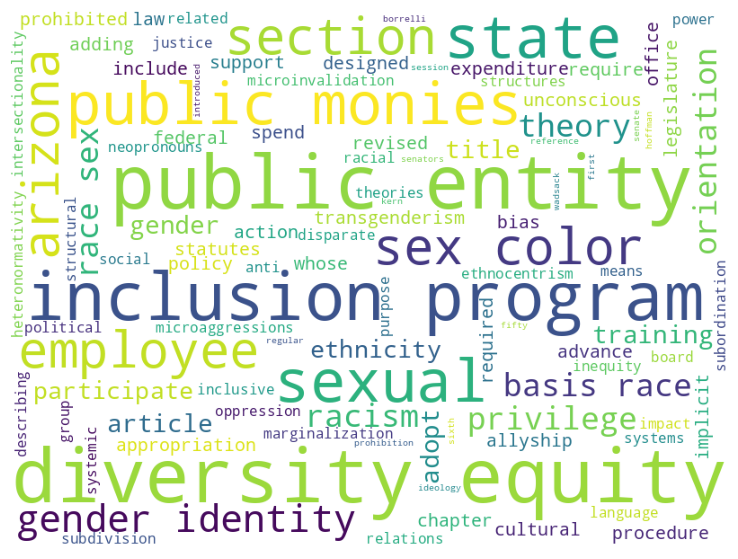

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(14, 7))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")

# Generate word cloud
wordcloud = WordCloud(
    width=800, 
    height=600,
    random_state=2, 
    background_color='white', 
    colormap='viridis', 
    collocations=True,
    collocation_threshold=30,
    stopwords=STOPWORDS,
    max_words=100,
    min_word_length=3,
    max_font_size=100,
    min_font_size=10,
    relative_scaling=0.8,
    prefer_horizontal=0.7,
)

wordcloud_plot = wordcloud.generate(' '.join(raw_tokens))

# Plot
wordcloud_plot.to_file('cloud.png')
plot_cloud(wordcloud_plot)